<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [4]:
import os;
os.listdir('/kaggle/input/magic04/')

['magic04.data']

In [5]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/magic04/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [6]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [7]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [8]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [9]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [10]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

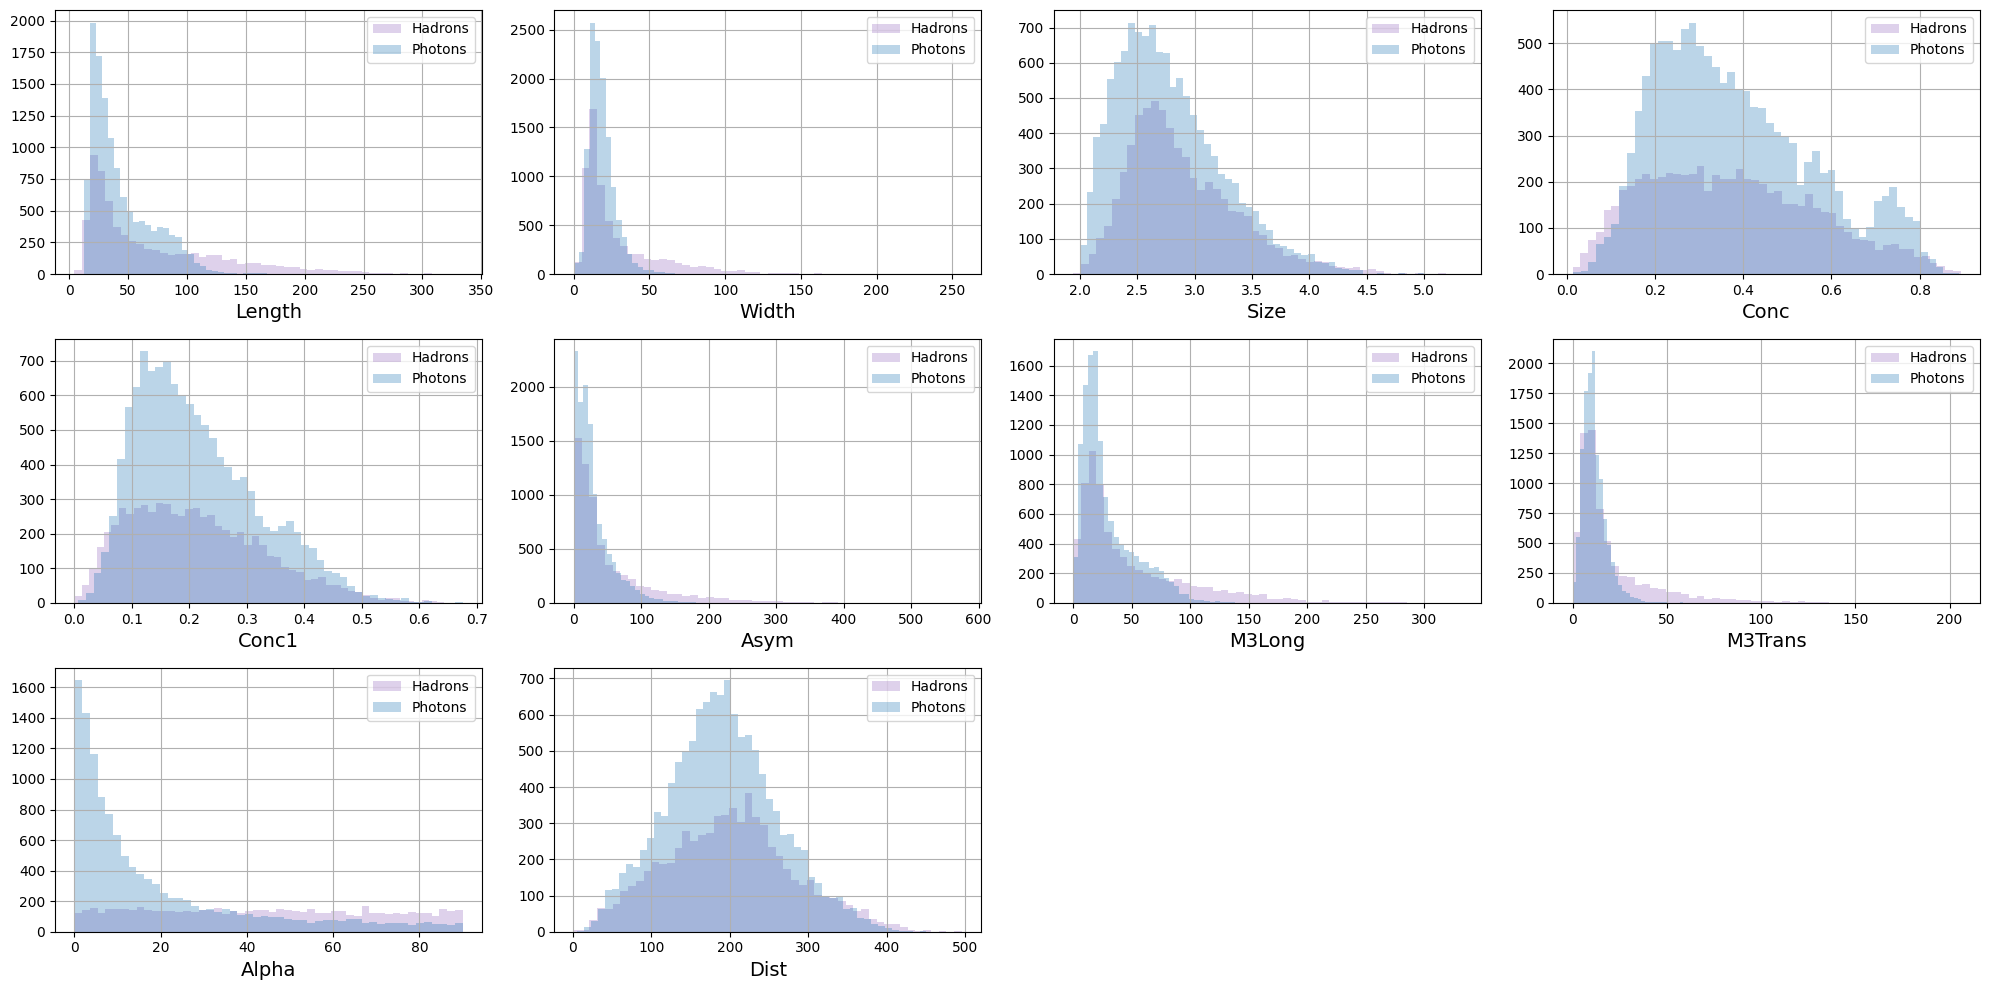

In [11]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [12]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

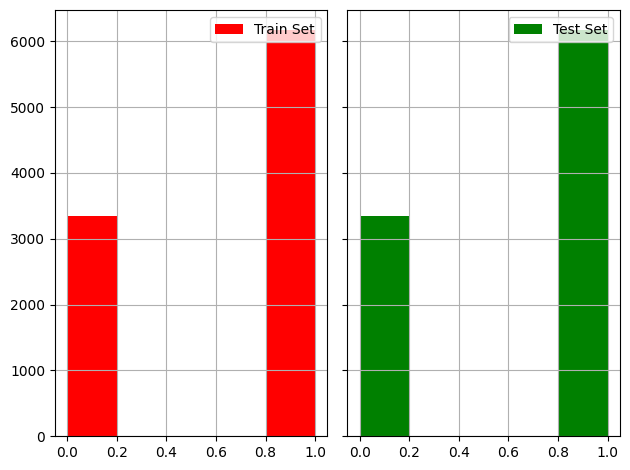

In [13]:
n_bins = 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(y_train, bins= n_bins, color = 'r', label = 'Train Set')
axs[0].legend(loc='upper right')
axs[0].grid()
axs[1].hist(y_test, bins= n_bins, color = 'g', label = 'Test Set')
axs[1].legend(loc='upper right')
axs[1].grid();

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [14]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution = 'normal', random_state=42)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

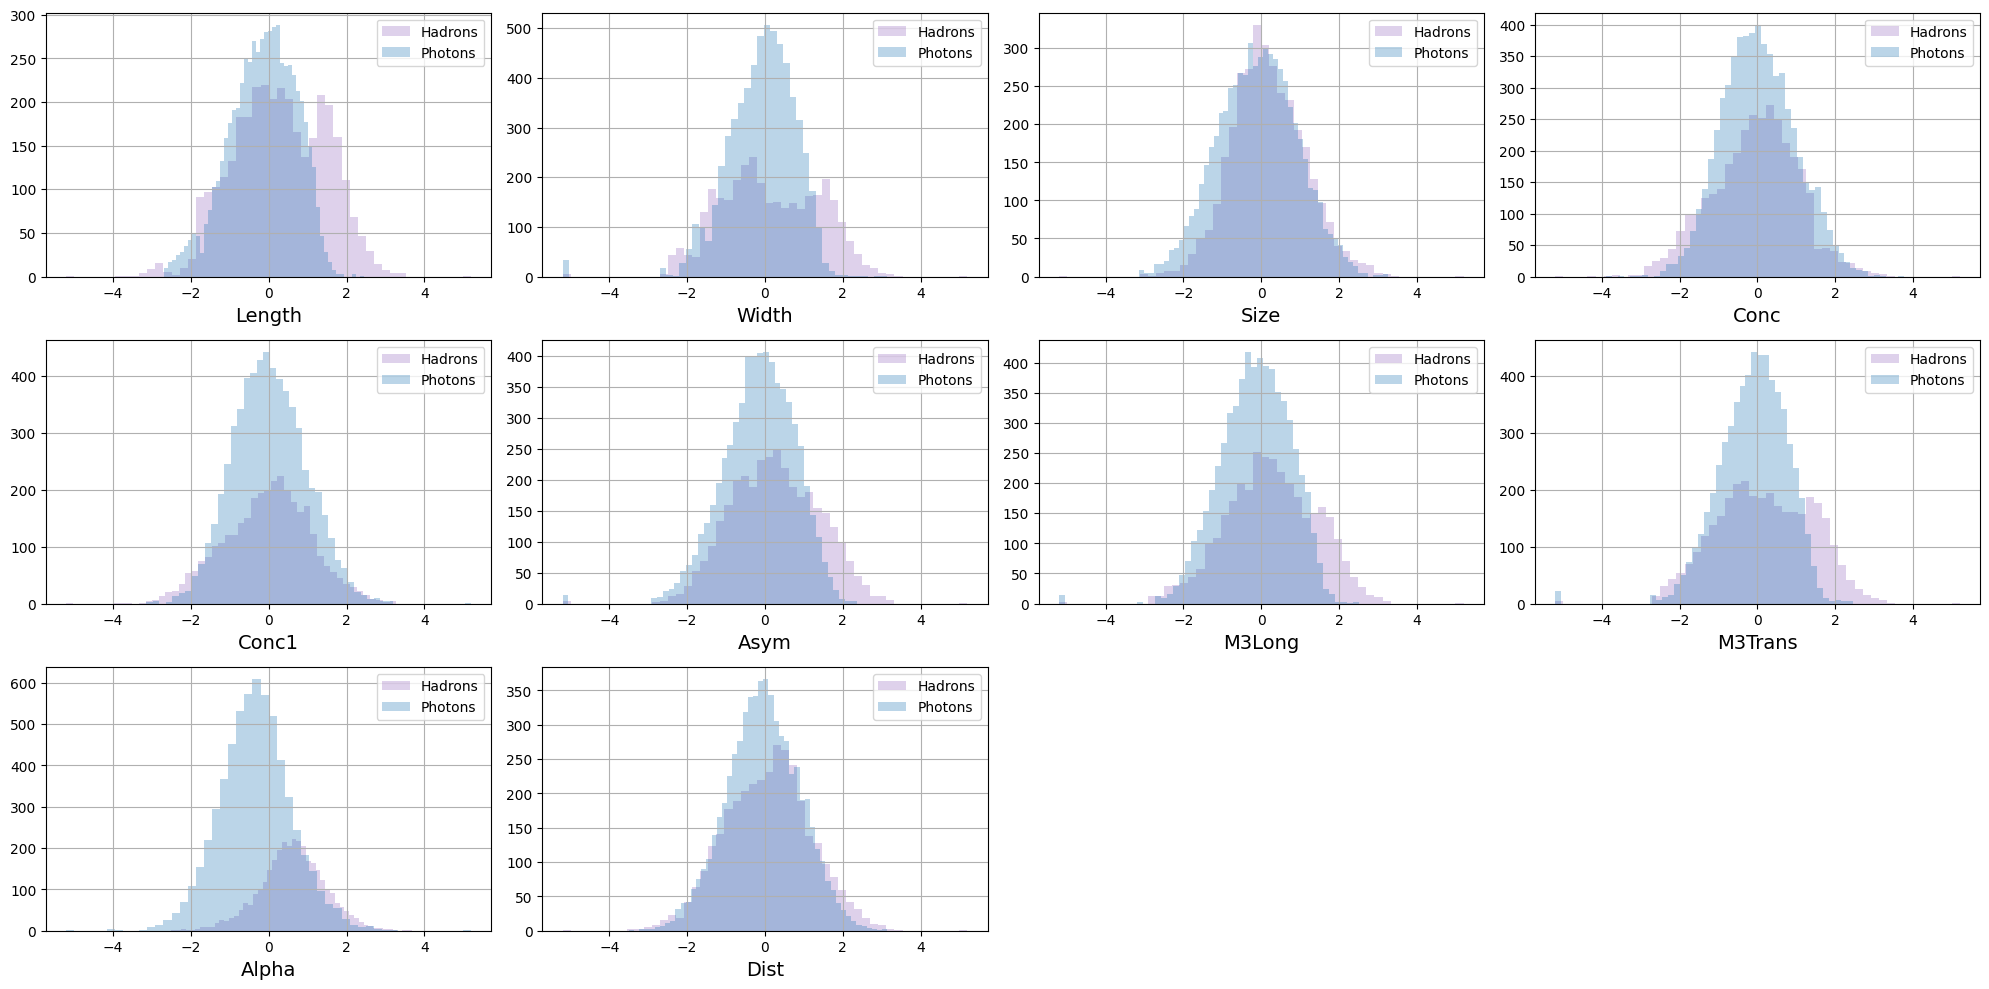

In [15]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

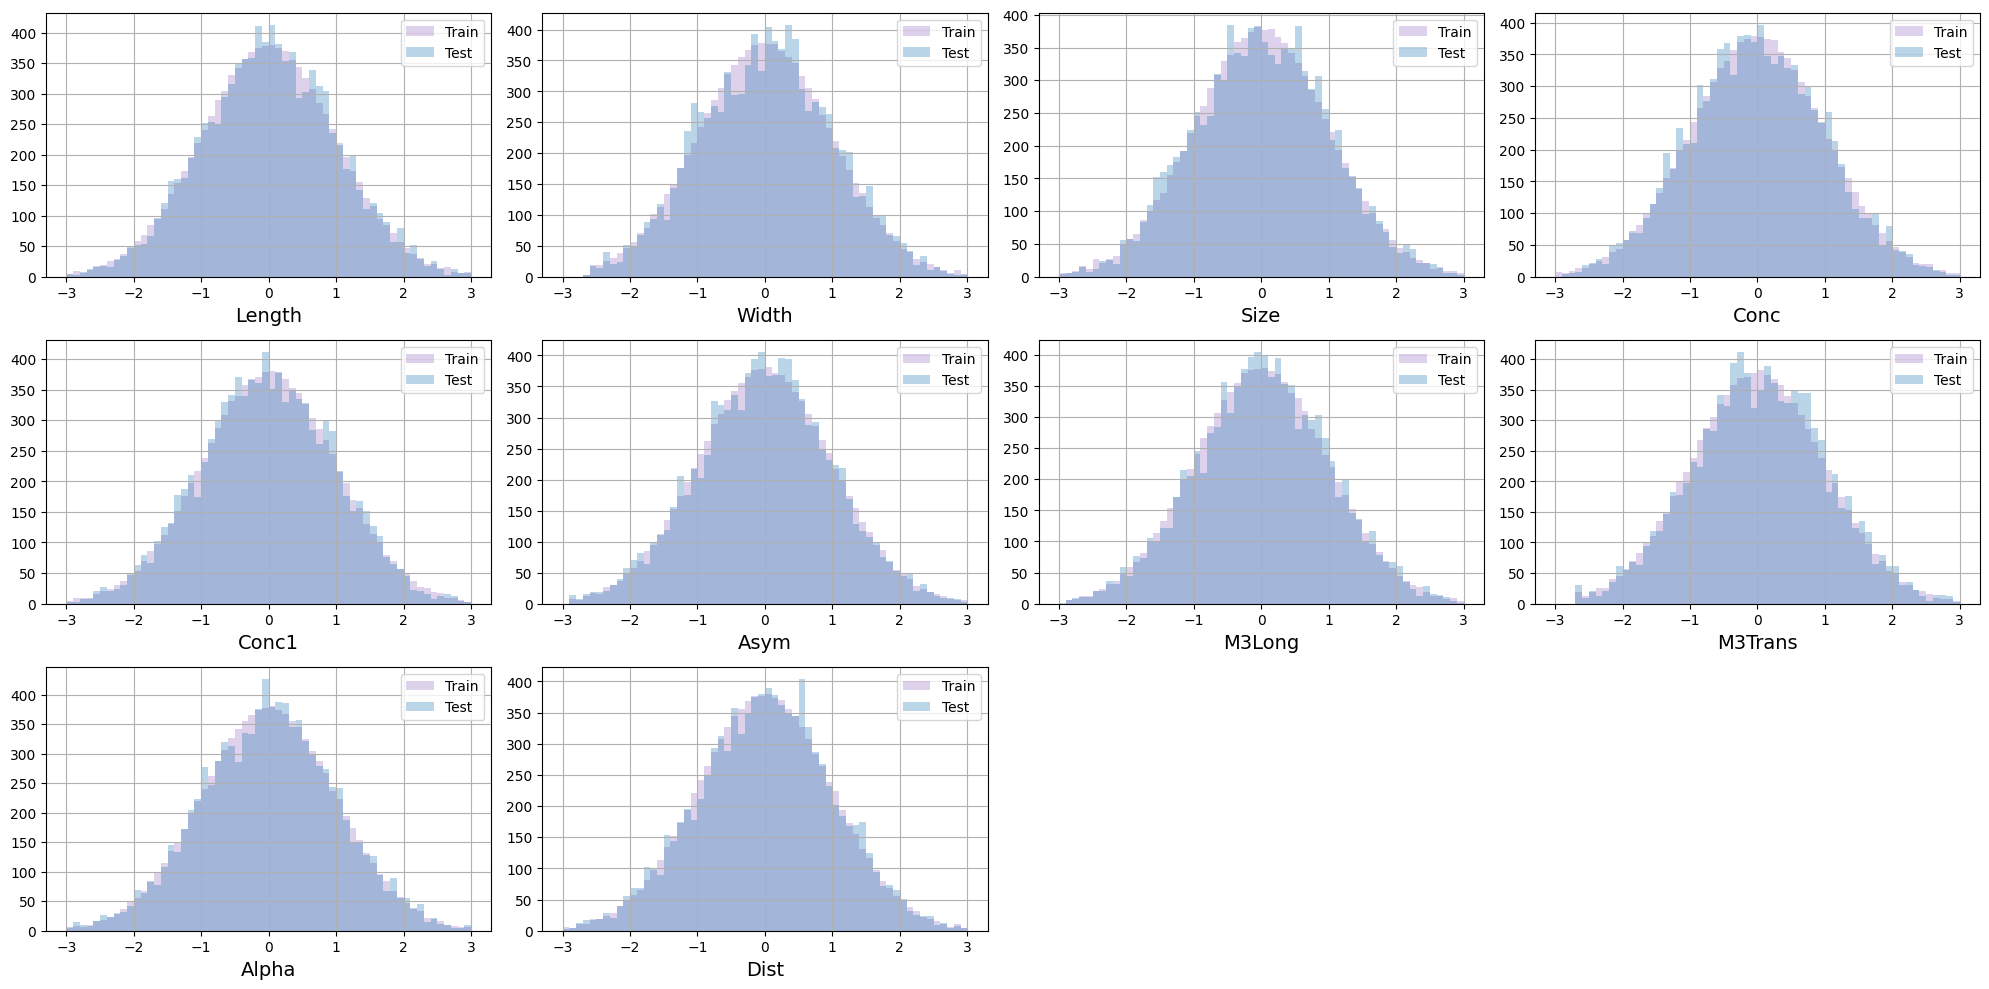

In [16]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [19]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
            )


    def forward(self, z, y):
        zy = torch.cat((z.cuda(), y.cuda()), dim=1)
        out = self.model(zy)
        
        return out

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [20]:
def generate(generator, y, latent_dim):
    y_tensor = torch.FloatTensor(y)
    z_tensor = torch.normal(0, 1, (len(y), latent_dim))
    
    with torch.no_grad():
        X_fake = generator(z_tensor.to(next(generator.parameters()).device),
                           y_tensor.to(next(generator.parameters()).device))
    
    return X_fake.cpu().detach().numpy()

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [21]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        xy = torch.cat((x.cuda(), y.cuda()), dim=1)
        out = self.model(xy)
        
        return out

Мне кажется, уместно использовать сигмоиду в качестве функции активации, потому что мы работаем с задачей бинарной классификации, а сигмоида позволяет перевести выход модели в диапазон от 0 до 1, и этот выход можно интерпретировать как вероятность принадлежности к классу.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [23]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    
    X_real = X_real.detach().cpu().numpy()
    y_real = y_real.detach().cpu().numpy()
    
    X_fake = X_fake.detach().cpu().numpy()
    y_fake = y_fake.detach().cpu().numpy()

    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, 
                                                                            test_size=0.25, stratify=y_real)
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake, y_fake,
                                                                            test_size=0.25, stratify=y_fake)
    X_train = np.vstack((X_real_train, X_fake_train))
    y_train = np.hstack((y_real_train, y_fake_train))
    
    X_test = np.vstack((X_real_test, X_fake_test))
    y_test = np.hstack((y_real_test, y_fake_test))
    
    lin_reg = LogisticRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, lin_reg.predict(X_test))

    boosting = GradientBoostingClassifier()
    boosting.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Думаю, нас больше всего бы устроило не очень высокое значение accuracy - около 0.5, потому что это будет значить, что мы сгенерировали фейковые объекты, которые сильно похожи на настоящие, и классификатор не может их хорошо отличить.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [24]:
from tqdm.auto import tqdm

In [25]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in tqdm(range(self.n_epochs)):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                X_fake = self.generator(Z_noise, cond_batch)
                
                for i in range(self.n_critic):
                    self.opt_disc.zero_grad()
                    real_mean = torch.mean(self.discriminator(real_batch, cond_batch))
                    fake_mean = torch.mean(self.discriminator(X_fake, cond_batch))
                    disc_loss = -real_mean + fake_mean         
                    disc_loss.backward(retain_graph=True)
                    
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.1, 0.1)
                        
                    self.opt_disc.step()
                    

                self.opt_gen.zero_grad()
                gen_loss = -torch.mean(self.discriminator(X_fake, cond_batch))
                gen_loss.backward()
                self.opt_gen.step()
                
                
            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score
    
            X_real_small = X_real[:1000]
            Z = torch.randn(1000, self.latent_dim)
            X_fake_small = self.generator(Z, y_cond[:1000])
            other_agent_score(X_real_small, torch.ones(1000), 
                              X_fake_small, torch.zeros(1000))
            

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [26]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=256,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

Linear regression score: 0.572
Boosting score: 0.894
Linear regression score: 0.616
Boosting score: 0.824
Linear regression score: 0.57
Boosting score: 0.806
Linear regression score: 0.654
Boosting score: 0.854
Linear regression score: 0.536
Boosting score: 0.734
Linear regression score: 0.598
Boosting score: 0.782
Linear regression score: 0.542
Boosting score: 0.732
Linear regression score: 0.518
Boosting score: 0.762
Linear regression score: 0.516
Boosting score: 0.668
Linear regression score: 0.514
Boosting score: 0.642
Linear regression score: 0.532
Boosting score: 0.67
Linear regression score: 0.468
Boosting score: 0.658
Linear regression score: 0.524
Boosting score: 0.652
Linear regression score: 0.458
Boosting score: 0.632
Linear regression score: 0.522
Boosting score: 0.658
Linear regression score: 0.508
Boosting score: 0.656
Linear regression score: 0.518
Boosting score: 0.64
Linear regression score: 0.498
Boosting score: 0.638
Linear regression score: 0.508
Boosting score: 0.

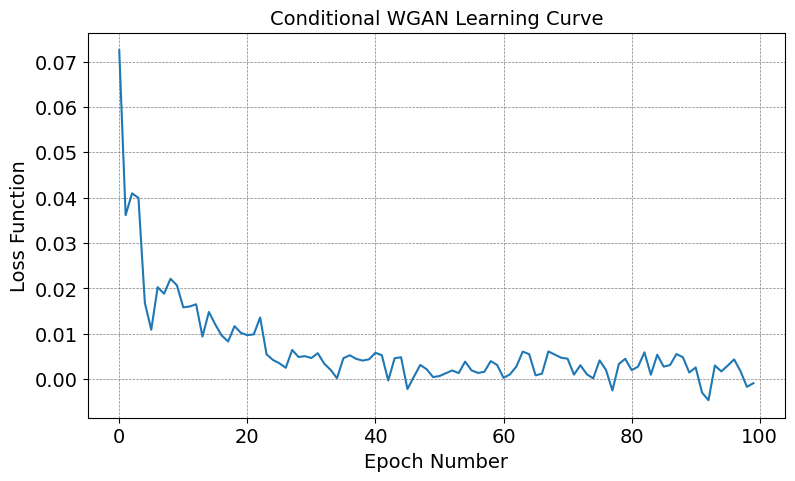

In [27]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [28]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

X_train_new = qt.inverse_transform(X_train)
X_fake_train_new = qt.inverse_transform(X_fake_train)

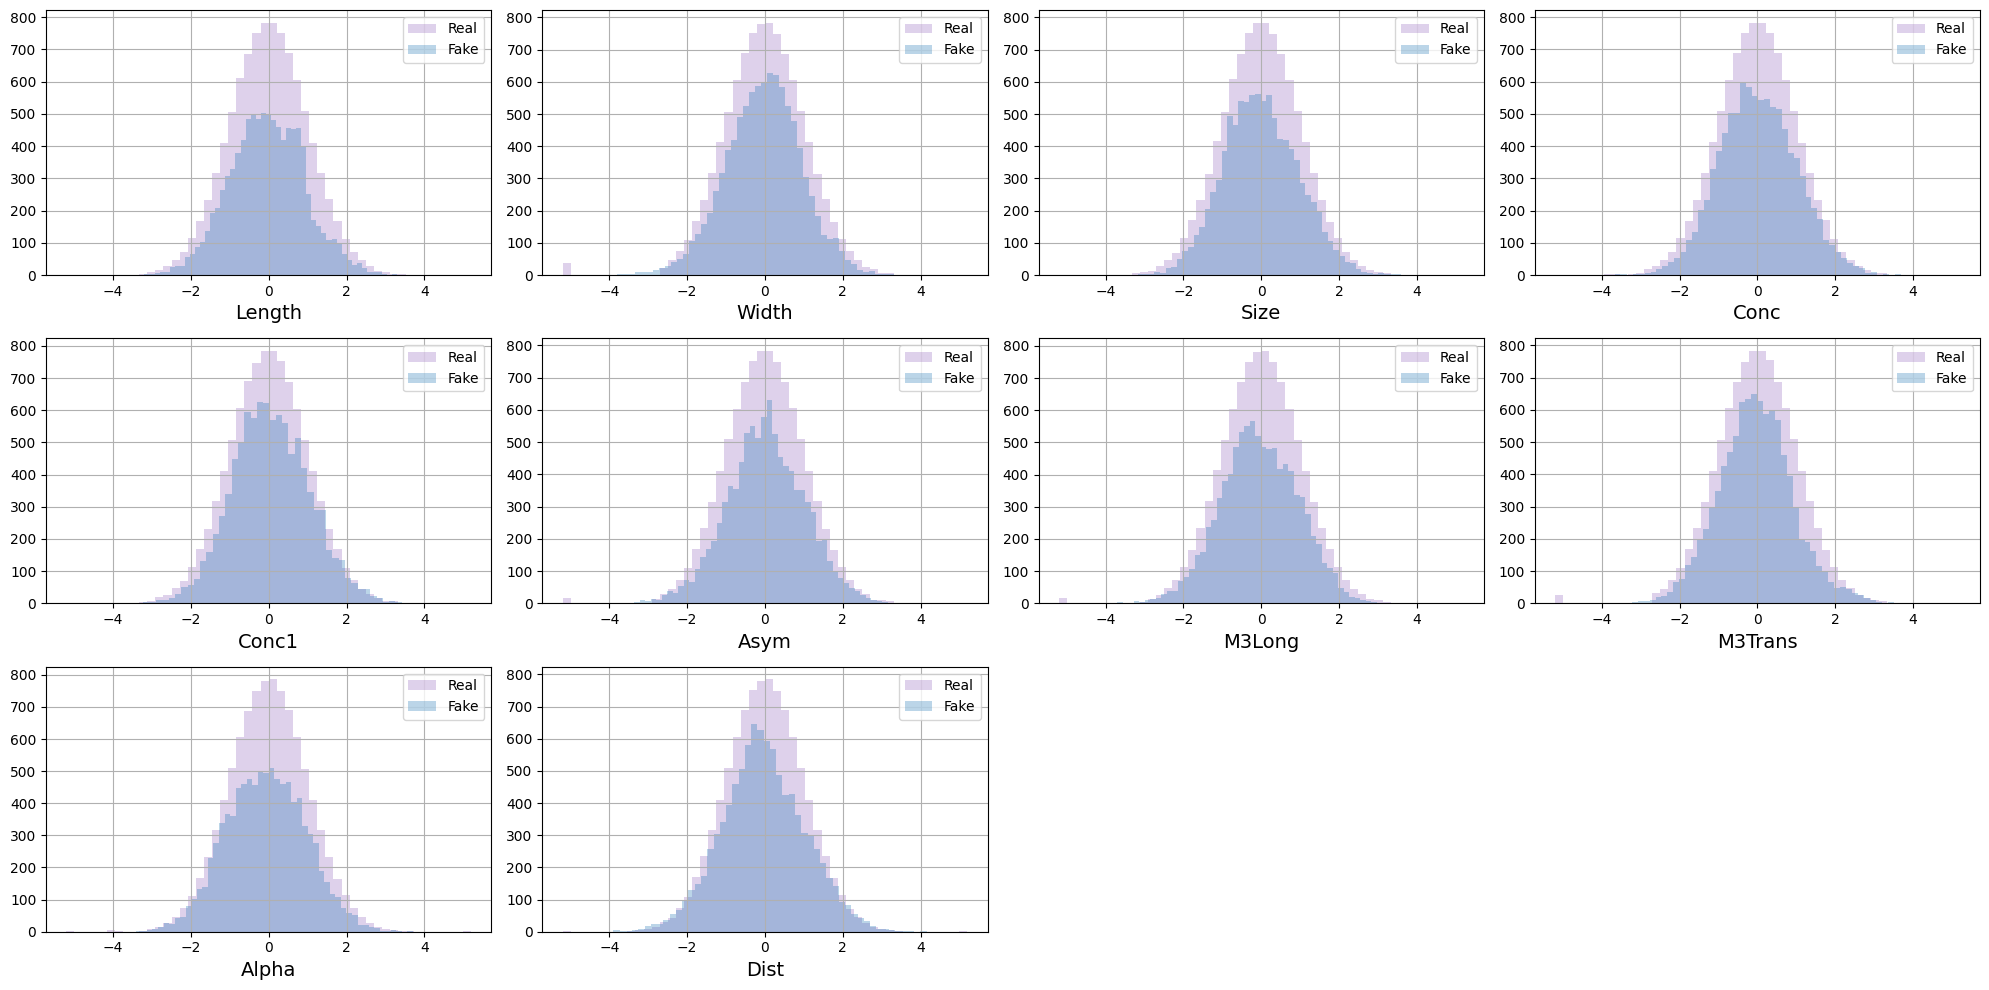

In [29]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [30]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

X_test_new = qt.inverse_transform(X_test)
X_fake_test_new = qt.inverse_transform(X_fake_test)

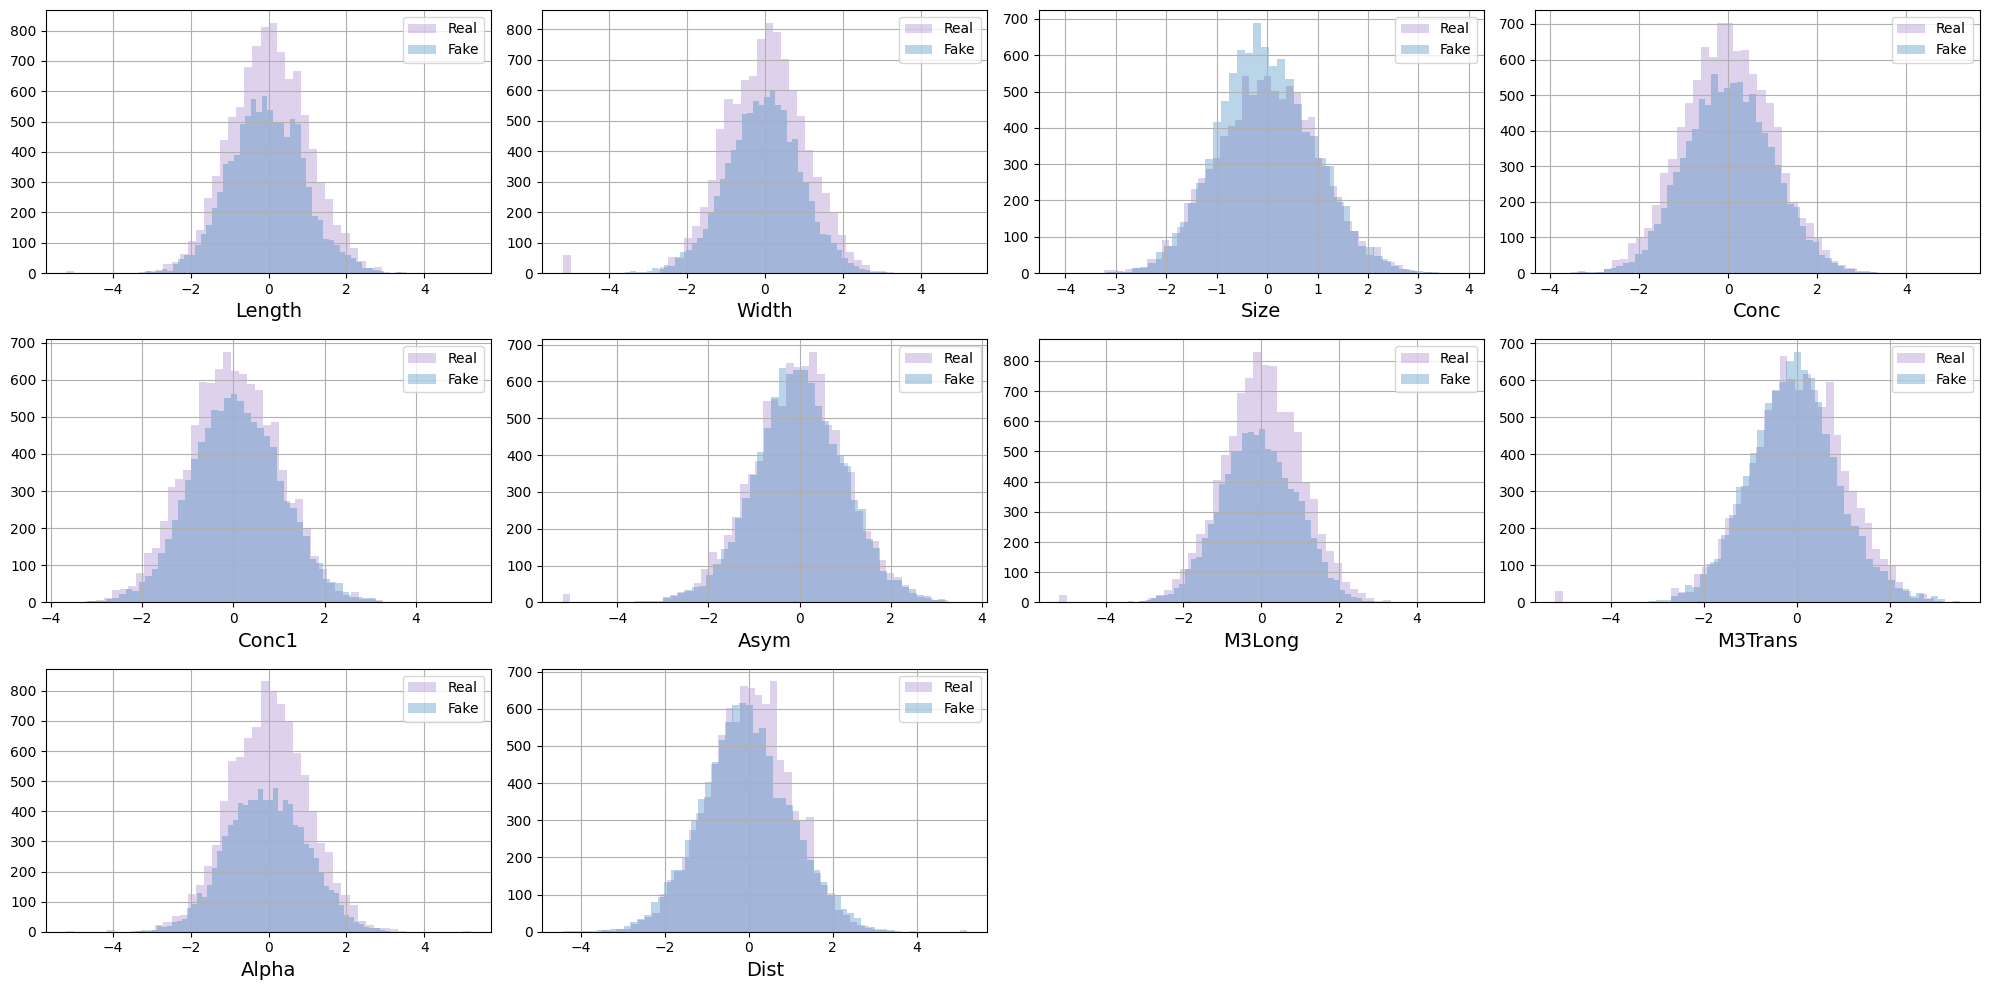

In [31]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [32]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [34]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6854279462318154


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Наш классификатор удовлетворительно различает настоящие и сгенерированные объекты. Разумеется, в идеале, объекты должны быть настолько похожими, чтобы классификатор не мог отличить фейковые и настоящие объекты лучше, чем случайный классификатор. То есть мы стремимся к значению площади под ROC около 0.5, что соотвествует случайному классификатору. Наши объекты получились более отличимыми, чем в идеале, значение AUC ROC 0.68. (Но это и не слишком плохой результат - градиентный бустинг даёт очень сильный классификатор, обычно его AUC ROC гораздо ближе к 1).

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [35]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tenosr of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    
    noise = torch.rand_like(x)
    amount = amount.view(amount.shape[0], 1)
    out = x * (1 - amount) + noise * amount
    
    return out

## Добавим sсheduler, он пригодится вам при обучении модели

In [36]:
pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
from diffusers import DDPMScheduler

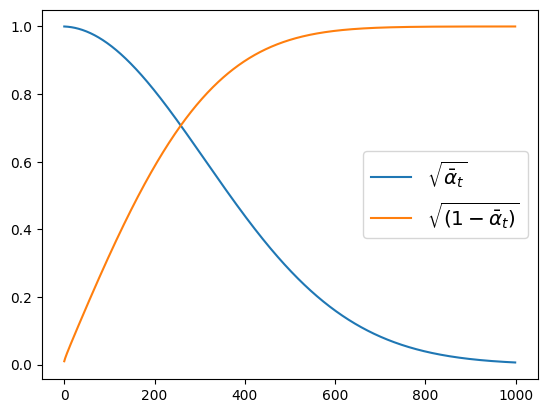

In [38]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [78]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_dim=100):
        super(DiffusionGenerator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(n_inputs, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_outputs))

    def forward(self, z, y):
        zy = torch.cat((z.cuda(), y.cuda()), dim=1)

        return self.model(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [79]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    X_fake = torch.rand((y.shape[0], latent_dim), dtype=torch.float, device=DEVICE)
    y = torch.as_tensor(y, dtype=torch.float, device=DEVICE)

    for i in scheduler.timesteps:
        with torch.no_grad():
            residuals = model(X_fake, y)
            previous_sample = scheduler.step(residuals, i, X_fake).prev_sample
            X_fake = previous_sample

    return X_fake.cpu().detach().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [80]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        self.model.to(DEVICE)


    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit
      
        for epoch in tqdm(range(self.n_epochs)):
            losses = []
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                
                amount = torch.rand(real_batch.shape).to(DEVICE)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                    (real_batch.shape[0],), device=DEVICE).long()
                
                noise = noise_scheduler.add_noise(real_batch, amount, timesteps)
            
                pred = self.model(noise, cond_batch)
                loss = self.loss(pred, real_batch)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                loss_epoch += loss.item()
                losses.append(loss.item())

            # caiculate and store loss after an epoch

            self.loss_history.append(sum(losses) / len(losses))
            print(sum(losses) / len(losses))

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score
            X_real_small = X_real[:1000]
            amount = torch.rand(X_real_small.shape[0]).to(DEVICE)
            X_noize_small = corrupt(X_real_small, amount)
            X_fake_small = self.model(X_noize_small, y_cond[:1000])
            other_agent_score(X_real_small, torch.ones(1000), 
                              X_fake_small, torch.zeros(1000))
 

        # Turn off training
        self.model.train(False)

In [81]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=256,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

0.6259430231232392
Linear regression score: 0.528
Boosting score: 0.77
0.4937813603564313
Linear regression score: 0.552
Boosting score: 0.702
0.49364874002180603
Linear regression score: 0.528
Boosting score: 0.726
0.4832863180260909
Linear regression score: 0.48
Boosting score: 0.72
0.48593867844656896
Linear regression score: 0.466
Boosting score: 0.742
0.47909668009532125
Linear regression score: 0.51
Boosting score: 0.702
0.4695675286807512
Linear regression score: 0.49
Boosting score: 0.7
0.47161560152706344
Linear regression score: 0.494
Boosting score: 0.7
0.4809811421130833
Linear regression score: 0.546
Boosting score: 0.708
0.4693032612926082
Linear regression score: 0.57
Boosting score: 0.72
0.4705016973771547
Linear regression score: 0.51
Boosting score: 0.736
0.4675974838043514
Linear regression score: 0.534
Boosting score: 0.666
0.4661553596195422
Linear regression score: 0.496
Boosting score: 0.718
0.48682834364865957
Linear regression score: 0.504
Boosting score: 0.718

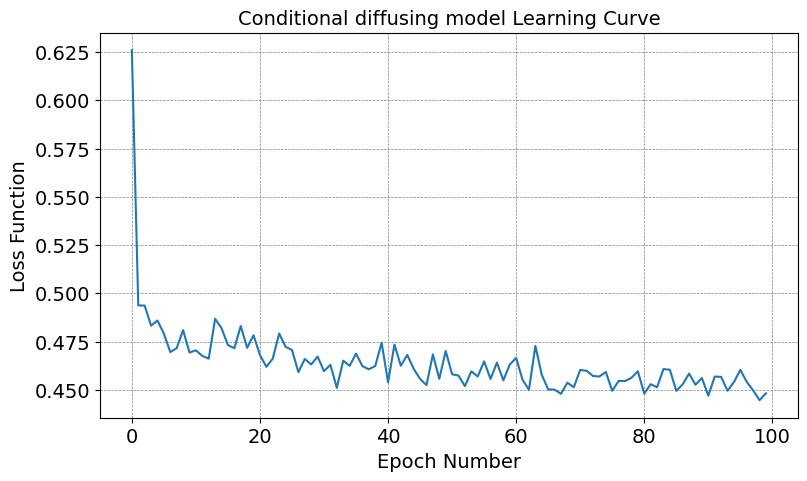

In [82]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [72]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, 
                                       latent_dim, noise_scheduler)
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, 
                                      latent_dim, noise_scheduler)

In [73]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [74]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score

accuracy = accuracy_score(yy_test, clf.predict(XX_test))
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)
print("Accuracy =", accuracy)

ROC AUC =  0.9965505953664359
Accuracy = 0.9679284963196635


Мы стали лучше отличать фейковые объекты от настоящих, значит, либо плохо работает генератор, либо слишком хорошо обучился дискриминатор. Это странно, судя по графику лосс очень хорошо шёл. Значит, нужно улучшать модель. GAN работает лучше, чем диффузионная модель, если сравнивать площади под roc-кривыми.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

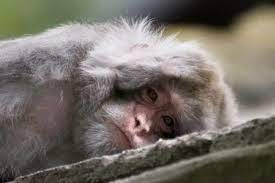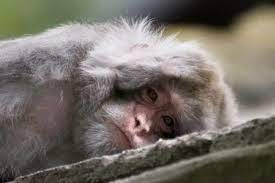

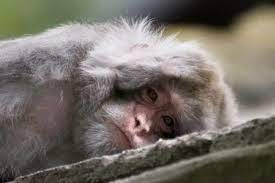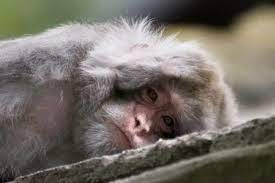